# Data Wrangling with MongoDB Project

After running **`project.py`**, the following codes are executed.

In [1]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd

client = MongoClient()
db = client.mydb

## Problems

There are several problems handling *.osm data.
 1. Key name should not have "." : 
     * So I changed "." to ":".
     * from `{ ..., u'cityracks.housenum': u'101', ... }`
     * to `{ ..., u'cityracks:housenum': u'101', ... }`
 1. [ISO 8601](http://en.wikipedia.org/wiki/ISO_8601) Format is hard to interpret
     * `{ ..., u'timestamp': u'2009-06-12T21:50:28Z',, ...}`
     * Using `dateutil.parser`, it can be converted to `datetime` object.
     * I could extract time information, such as year, month, day, hour and minute.
 1. Nodes with no tag have few information.
     * Only 20% nodes have useful tags.

In [2]:
print "Ratio of nodes with tags : {0:2.2f}%".format( float(db.osmdb.find({"tags" : {"$exists" : 1}}).count()) 
                                                     / float(db.osmdb.find().count()) * 100)

Ratio of nodes with tags : 19.60%


## Data Overview

In [3]:
print "Number of documents : {0}".format( db.osmdb.find().count() )
print "Number of unique users : {0}".format( len(db.osmdb.distinct("user")) )

Number of documents : 1665820
Number of unique users : 1249


### Top 10 Contributing users

In [4]:
query = [
	{"$group" : {"_id" : "$user", "count" : {"$sum": 1 }}},
	{"$sort" : {"count" : -1}},
	{"$limit" : 10}
]
res = db.osmdb.aggregate(query)['result']
pprint(res)
df = pd.DataFrame.from_dict(res)
theuser = res[0]['_id'] # The top 1 user.

[{u'_id': u'Rub21_nycbuildings', u'count': 1155679},
 {u'_id': u'ingalls_nycbuildings', u'count': 105393},
 {u'_id': u'lxbarth_nycbuildings', u'count': 77586},
 {u'_id': u'robgeb', u'count': 52913},
 {u'_id': u'Korzun', u'count': 35156},
 {u'_id': u'woodpeck_fixbot', u'count': 16393},
 {u'_id': u'ingalls', u'count': 14371},
 {u'_id': u'celosia_nycbuildings', u'count': 13505},
 {u'_id': u'NE2', u'count': 10262},
 {u'_id': u'aaron_nycbuildings', u'count': 10196}]


### Top 10 appearing amenities

In [5]:
query = [
	{"$match" : {"tags.amenity" : {"$exists" : 1}}},
	{"$group" : {"_id" : "$tags.amenity", "count" : {"$sum" : 1}}},
	{"$sort" : {"count" : -1}},
	{"$limit" : 10}
]
res = db.osmdb.aggregate(query)['result']
pprint(res)
df = pd.DataFrame.from_dict(res)

[{u'_id': u'bicycle_parking', u'count': 3403},
 {u'_id': u'restaurant', u'count': 1105},
 {u'_id': u'place_of_worship', u'count': 866},
 {u'_id': u'school', u'count': 743},
 {u'_id': u'parking', u'count': 654},
 {u'_id': u'cafe', u'count': 436},
 {u'_id': u'fast_food', u'count': 306},
 {u'_id': u'bank', u'count': 275},
 {u'_id': u'embassy', u'count': 203},
 {u'_id': u'bench', u'count': 186}]


## Other Ideas

 : I used `rpy2` python library, used for R code in python script.

### Top 1 User's Patterns

In [6]:
%load_ext rmagic 

/Library/Python/2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


#### Monthly Pattern

1. `Rub21_nycbuildings` started his Manhattan activities from Dec, 2013 to June, 2014.
1. The highest number of commits happened in 2014-05.
1. It is very surprising that for 6 months `Rub21_nycbuildings` did all commits to Manhattan.

In [7]:
query = [
	{"$match" : {"user" : theuser}},
    {"$group" : {"_id" : "$timeInfo.YM", "count" : {"$sum" : 1}}}
]
res = db.osmdb.aggregate(query)['result']
df = pd.DataFrame.from_dict(res)

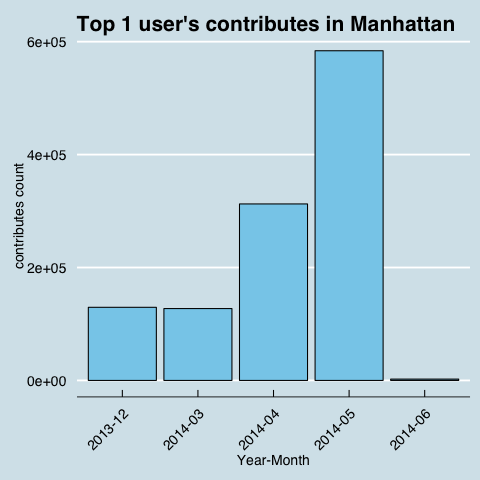

In [8]:
%%R -i df
df <- as.data.frame(df)
library(ggplot2)
library(ggthemes)
ggplot(aes(x = X_id, y = count), data = df) + 
    theme_economist(14) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    geom_bar(stat = "identity", color = I('black'), fill = I('skyblue')) +
    xlab('Year-Month') + 
    ylab('contributes count') +
    ggtitle("Top 1 user's contributes in Manhattan")

#### Weekly Pattern

1. From Sunday to Thursday, `Rub21_nycbuildings` did his contributes to Manhattan.
1. However, on the weekend, his records were realtively very low.

In [9]:
query = [
	{"$match" : {"user" : theuser}},
    {"$group" : {"_id" : "$timeInfo.dayOfWeek", "count" : {"$sum" : 1}}}
]
res = db.osmdb.aggregate(query)['result']
pprint(res)
df = pd.DataFrame.from_dict(res)

[{u'_id': u'SAT', u'count': 14449},
 {u'_id': u'FRI', u'count': 1843},
 {u'_id': u'WED', u'count': 232564},
 {u'_id': u'THU', u'count': 316485},
 {u'_id': u'MON', u'count': 108784},
 {u'_id': u'SUN', u'count': 291696},
 {u'_id': u'TUE', u'count': 189858}]


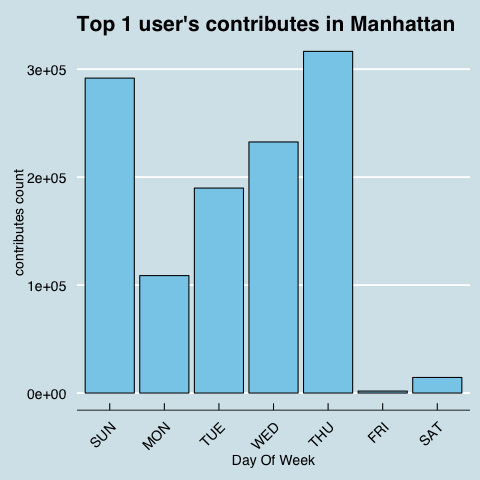

In [10]:
%%R -i df
df <- as.data.frame(df)
# Sort Day Of Weeks
df$X_id = factor(df$X_id, levels = c("SUN", "MON", "TUE", "WED", "THU", "FRI", "SAT"))
library(ggplot2)
library(ggthemes)
ggplot(aes(x = X_id, y = count), data = df) + 
    theme_economist(14) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    geom_bar(stat = "identity", color = I('black'), fill = I('skyblue')) +
    xlab('Day Of Week') + 
    ylab('contributes count') +
    ggtitle("Top 1 user's contributes in Manhattan")

###Detail about Amenity : restaurant

1. Manhattan is an international place.
1. So there are many restaurants providing international food.
1. I give you a plot to show top 20 foods.

In [11]:
query = [
	{"$match" : {"tags.amenity" : {"$exists" : 1}, 
                 "tags.amenity" : "restaurant", 
                 "tags.cuisine" : {"$exists" : 1}}},
	{"$group" : {"_id" : "$tags.cuisine", "count" : {"$sum" : 1}}},
	{"$sort" : {"count" : -1}},
	{"$limit" : 20}
]
res = db.osmdb.aggregate(query)['result']
df = pd.DataFrame.from_dict(res)

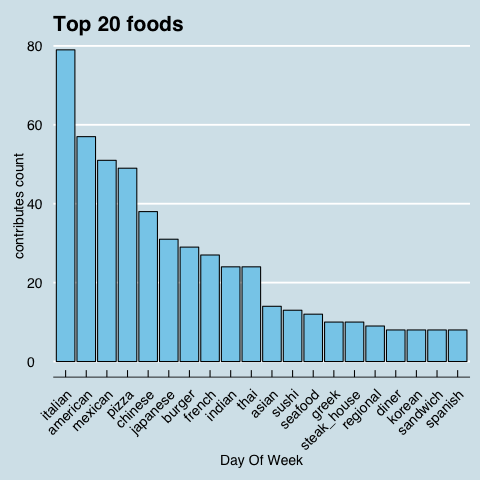

In [12]:
%%R -i df
df <- as.data.frame(df)
library(ggplot2)
library(ggthemes)
ggplot(aes(x = reorder(X_id, -count), y = count), data = df) + 
    theme_economist(14) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    geom_bar(stat = "identity", color = I('black'), fill = I('skyblue')) +
    xlab('Day Of Week') + 
    ylab('contributes count') +
    ggtitle("Top 20 foods")

## Conclusion

In Manhattan, a large of portion of `OpenStreetMap` database is constructed by top 1 user,  `Rub21_nycbuildings`. 
`Rub21_nycbuildings`'s working period spaned from 2013-12 to 2014-06, about 6 months. It is very impressive to do so much works by just one user. I think that this ID might be shared by several users, or companies.

In addition, restaurants in Manhattan are very international. They are providing various coutries food, such as Europe, USA, Japanese, India. The higest count food genre is 'italian', like pasta and pizza.